In [1]:
import os
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

#imports needed for dbtex function
print('---dbtex installs---')
!pip3 install -q pylibjpeg  #for dbtex
!pip3 install -q python-gdcm
!pip3 install -q pylibjpeg-libjpeg 
!pip3 install -q pylibjpeg-openjpeg
!pip3 install -q Pillow


import PIL
import pylibjpeg

#
# Load data from google drive
#

drive.mount('/content/gdrive')

     |████████████████████████████████| 1.9MB 5.2MB/s 
     |████████████████████████████████| 133kB 5.2MB/s 
---dbtex installs---
     |████████████████████████████████| 890kB 9.2MB/s 
     |████████████████████████████████| 3.6MB 44.9MB/s 
     |████████████████████████████████| 9.4MB 4.3MB/s 
     |████████████████████████████████| 4.2MB 7.0MB/s 
Mounted at /content/gdrive


In [2]:
#code borrowed from
#https://gist.github.com/cmarasinou/7c990a4835e80874b4de5f2433612d65
###############testing out embedded function, as .py import failing

from typing import AnyStr, BinaryIO, Optional, Union

import numpy as np
import pydicom as dicom
from skimage.exposure import rescale_intensity


def dcmread_image(
    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
    view: str,
    index: Optional[np.uint] = None,
) -> np.ndarray:
    """Read pixel array from DBT DICOM file"""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name='pillow') #pylibjpeg')
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
        print("Laterality fixed!")
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(
        pixel_array, in_range=(low, high), out_range="dtype"
    )
    return pixel_array


def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Unreliable - DICOM laterality is incorrect for some cases"""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value


def _get_image_laterality(pixel_array: np.ndarray) -> str:
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"


def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)


def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

In [5]:
def read_single_dbt(dcm_full_file,view_type):
#read in a single dicom formatted file and output the full volume array
    dcm_full_file = os.path.join(upper_dir,patient_id, patient_uid, view_number,dcm_file)
    img_data = dcmread_image(dcm_full_file,view_type)
    return img_data

In [6]:
#Sample code to test out the function on one file


dcm_full_file = '/content/gdrive/My Drive/DBT_DATA/TEST_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00118/01-01-2000-DBT-S05386-MAMMO screening digital bilateral-70928/7697.000000-17471/1-1.dcm'
view_type = 'rcc'
img_data = dcmread_image(dcm_full_file,view_type)


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


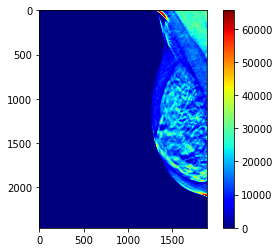

In [7]:
#check out the single loaded volume
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img_data[10,:,:],cmap='jet')
plt.colorbar()
